# Twitter Sentiment Analysis - AIR Project

**1. Importing libraries and installing tweepy**

In [61]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Flatten, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from wordcloud import WordCloud
import time
import itertools
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
!pip install tweepy

In [63]:
import tweepy

In [64]:
#twitter API credentials
consumerKey = "V0AbktVHuciimTCOXSgU7Zbfc"
consumerSecret = "mREamg9BsZoJsIZNwDORE50GS7ZqWM9uAz5roornoIxj46xCgR"
accessToken = "1190269761948663809-ucGSjbsNsAaWerbXotnidWkEaxdc3M"
accessTokenSecret = "1vRd2O2IlGxeLc9BEc2zrimB8q0yCukFUHq7Mx5zSRbiG"

#create authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
#Set access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
#Create the API object while passing in the auth info
api = tweepy.API(authenticate)

#extract 10 tweets
posts = api.user_timeline(screen_name = "BillGates", count = 10, lang = "en", tweet_mode="extended")
for tweet in posts:
    print(tweet.full_text + '\n')

I am in awe of people who have dedicated their lives to making the world a more equitable place, and I feel lucky to be able to support their efforts. https://t.co/It4s0WRzH5

You don’t need to be a big soccer fan to recognize why it’s called “the beautiful game.” https://t.co/Bkiar7eYUu

RT @gatesfoundation: This is a major milestone in the fight against #malaria. Now, millions more people have access to a powerful new tool…

RT @AP: The major advance in fusion research announced on  Tuesday was decades in coming, with scientists for the first time able to engine…

In order to solve our world’s sanitation crisis, we need smarter toilets that don’t rely on sewage systems and prevent the spread of diseases. #WorldToiletDay https://t.co/gbp9F0GxlE

Collaboration and more open access to data have made seemingly impossible health breakthroughs a reality, like COVID-19 vaccines. @AlzData is putting the power of data behind one of our most critical health challenges. https://t.co/Qtatf2WMds


**2. Loading Data**

In [65]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header = None)
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'tweet']
df.head(10)

,sentiment,ID,date,query,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


Only keep the columns needed for sentiment analysis and change sentiment to positive or negative.

In [66]:
data = df.drop(['ID', 'date', 'query', 'username'], axis = 1)
sent = { 0: 'Negative', 4: 'Positive'}
def label_decoder(label):
    return sent[label]

data.sentiment = data.sentiment.apply(lambda x : label_decoder(x))
data.head()

,sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Negative    800000
Positive    800000
Name: sentiment, dtype: int64


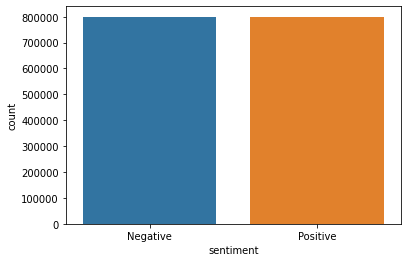

In [67]:
plt.figure()
sns.countplot(data['sentiment'])
print(data['sentiment'].value_counts())

**3. Preprocessing**

In [68]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text, stem = False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', text)
    text = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', text)
    text = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', text)
    text = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', text)
    text = re.sub("[^a-z0-9<>]", ' ', text)
    tokens =[]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

Test a tweet to see the difference before and after preprocessing

In [69]:
data.tweet[24821]

"I say &quot;I've got a 16GB flashdrive&quot;. He says &quot;I *saw* a 64GB flashdrive&quot;. Somehow his statement trumps mine. "

In [70]:
preprocess(data.tweet[24821], True)

'say quot got 16gb flashdriv quot say quot saw 64gb flashdriv quot somehow statement trump mine'

Apply preprocessing to all the data

In [71]:
data.tweet = data.tweet.apply(lambda x : preprocess(x))
data.head()

,sentiment,tweet
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result school today also blah
2,Negative,dived many times ball managed save 50 rest go bounds
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [72]:
processedtext = list(data.tweet)
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

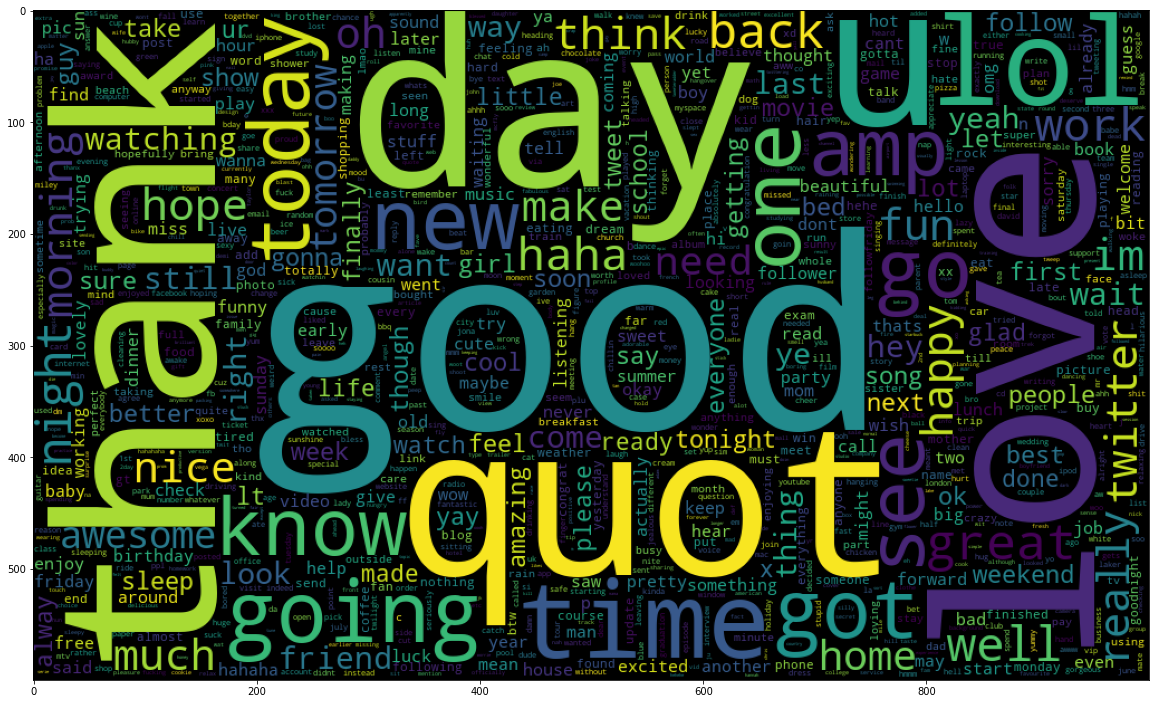

In [73]:
word_cloud = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(word_cloud)

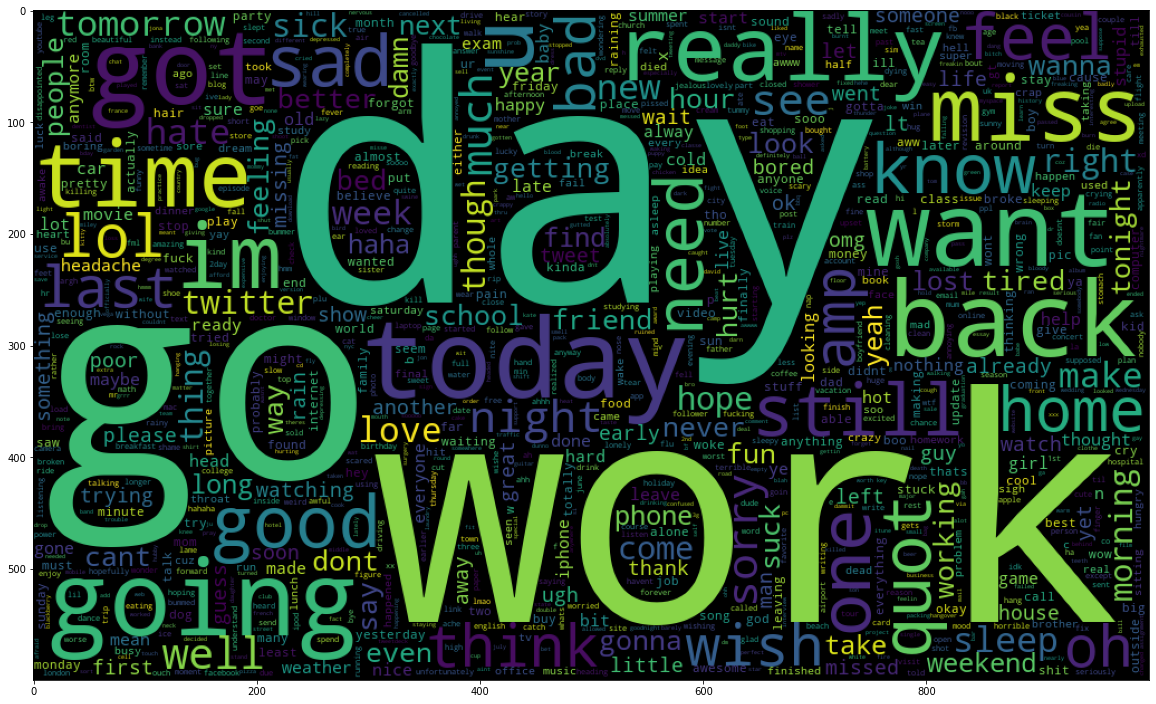

In [74]:
wc = WordCloud(max_words = 1000 , width = 1000 , height = 600,
              collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Pull data about specific topics to and see how many tweets are positive versus negative about this topic

In [75]:
data = shuffle(data)
searchWords = '|'.join(['sport', 'player', 'game', 'ball', 'score', 'winner'])
filtered = data[data['tweet'].str.contains(searchWords, case=False)]
pd.set_option('display.max_colwidth', 0)
print("Amount of positive tweets:", filtered['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered['sentiment'].value_counts()['Negative'])
filtered.head(10)

Amount of positive tweets: 11747
Amount of negative tweets: 12274


,sentiment,tweet
755685,Negative,talk game makes think dammit lost game
11058,Negative,ok battery almost dead need stop twittering watching scores
273118,Negative,isplayer died sorry
422148,Negative,time get lost movie video game buzz leaving probaly best dont wanna wake hung goodnight twitter heads
701395,Negative,back paintballing sore move
1372624,Positive,whew close game grrrreat win fiiiinally sheesh knew u could
222525,Negative,hmm pens lose cavs lose started promising sports night
1053643,Positive,watching love amp basketball sigh
1086712,Positive,missed game thanks 2 twitter know lakers r finals know could checked nba com twitter much better
511354,Negative,curled ball feel soo sicckkkkk today leavers day boohooo


In [76]:
searchWords = '|'.join(['job', 'work', 'weekday', 'commute'])
filtered1 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered1['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered1['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered1.head(10)

Amount of positive tweets: 35628
Amount of negative tweets: 67046


,sentiment,tweet
786691,Negative,much flow today worries feeling fear good enough help wrt bliss meanwhile still working hard amp
545824,Negative,lj layouts working
213680,Negative,luhv new song quot paranoid quot jobros dont itunes buy
238578,Negative,hahaha feel way major especially economy jobs
1201075,Positive,cravenjade back later work unfortunately
502912,Negative,hehe feel drunk even without alcohol im still unable take leave work
86202,Negative,soo busy everywhere weather soo nice love spring almost work
762184,Negative,someone remind going work early means getting done early
927395,Positive,3 days work week indesign course thurs amp fri
1218619,Positive,heat stop workout feel pumped guess got pep back


In [77]:
searchWords = '|'.join(['Obama', 'Trump', 'politics', 'president', 'election'])
filtered2 = data[data['tweet'].str.contains(searchWords, case=False)]
print("Amount of positive tweets:", filtered2['sentiment'].value_counts()['Positive'])
print("Amount of negative tweets:", filtered2['sentiment'].value_counts()['Negative'])
pd.set_option('display.max_colwidth', 0)
filtered2.head(10)

Amount of positive tweets: 978
Amount of negative tweets: 1209


,sentiment,tweet
768107,Negative,ty normally try 2avoid politics 4this time 2b startrek alien woman god bless troops freedom
725447,Negative,hard sleep iranelection mind
1121635,Positive,zachnyc obamas r coming nyc tonight secret date place bets rockofages relive hair metal days
995919,Positive,sleep good night everybody hope trump wake tonight
463049,Negative,needs die dumb president
1566869,Positive,oh good go career politics would natural
479729,Negative,summer election
394263,Negative,lucky u wish school would one school president lazy
205819,Negative,found sister going beach like atlantic ocean trumped outing
455049,Negative,sad day british politics


**4. Split data into training and testing sets**

In [78]:
Train_size = 0.8
max_words = 100000
max_length = 30

In [79]:
train_data, test_data = train_test_split(data, test_size = 1 - Train_size, random_state = 5)
print('size of training data :', len(train_data))
print('size of testing data :',len(test_data))

size of training data : 1280000
size of testing data : 320000


In [80]:
train_data.head()

,sentiment,tweet
1585891,Positive,miss swoons congratulations two
1571807,Positive,love ure hair demi
1396271,Positive,done anything much today lunch together thing first time nice next afternoon kip
814229,Positive,yeaa ano amazing invention
28465,Negative,boooo got tweet late im outtie pool parties


In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('VOCAB_SIZE :', vocab_size)

VOCAB_SIZE : 290585


In [82]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = max_length)

print('training x shape :', x_train.shape)
print('testing x shape :', x_test.shape)

training x shape : (1280000, 30)
testing x shape : (320000, 30)


In [83]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.tolist())
y_test = encoder.transform(test_data.sentiment.tolist())

y_train = y_train.reshape(1280000,1)
y_test = y_test.reshape(320000,1)

print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

y_train shape : (1280000, 1)
y_test shape : (320000, 1)


Import word embeddings and create representations of word vectors for the tweets in our dataset. 

In [84]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-09 22:23:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-09 22:23:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-09 22:23:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [85]:
GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [86]:
embeddings_index = {}
file = open(GLOVE_EMB)
for line in file:
    values = line.split()
    word = value = values[0]
    coef = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coef
    
file.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [87]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**5. Begin Training**

In [88]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                           EMBEDDING_DIM,
                                           weights = [embedding_matrix],
                                           input_length = max_length,
                                           trainable = False)

In [89]:
input_shape = Input(shape = (max_length), dtype = 'int32')
embedding_sequence = embedding_layer(input_shape)
x = SpatialDropout1D(0.2)(embedding_sequence)
x = Conv1D(64, 5, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
output = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(input_shape, output)

2023-01-09 22:27:19.432830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 22:27:19.576136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 22:27:19.576959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 22:27:19.578227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [90]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87175500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 64)            256       
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 256)               33024 

In [91]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss ='binary_crossentropy',
             metrics = ['accuracy'])

reduction = ReduceLROnPlateau(factor = 0.1,
                                min_lr = 0.0001,
                                monitor = 'val_loss',
                                verbose = 1)
history = model.fit(x_train,
                   y_train,
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   validation_data = (x_test, y_test),
                   callbacks = [reduction])

2023-01-09 22:27:23.603350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 153600000 exceeds 10% of free system memory.
2023-01-09 22:27:23.799009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-09 22:27:27.837117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7383

2023-01-09 22:29:37.857404: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


1250/1250 [==============================] - 139s 103ms/step - loss: 0.5204 - accuracy: 0.7383 - val_loss: 0.4813 - val_accuracy: 0.7666
Epoch 2/20
1250/1250 [==============================] - 128s 103ms/step - loss: 0.4867 - accuracy: 0.7624 - val_loss: 0.4692 - val_accuracy: 0.7738
Epoch 3/20
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4761 - accuracy: 0.7695 - val_loss: 0.4676 - val_accuracy: 0.7761
Epoch 4/20
1250/1250 [==============================] - 127s 102ms/step - loss: 0.4696 - accuracy: 0.7739 - val_loss: 0.4607 - val_accuracy: 0.7793
Epoch 5/20
1250/1250 [==============================] - 128s 102ms/step - loss: 0.4653 - accuracy: 0.7764 - val_loss: 0.4592 - val_accuracy: 0.7805
Epoch 6/20
1250/1250 [==============================] - 127s 101ms/step - loss: 0.4619 - accuracy: 0.7790 - val_loss: 0.4566 - val_accuracy: 0.7816
Epoch 7/20
1250/1250 [==============================] - 127s 101ms/step - loss: 0.4590 - accuracy: 0.7807 - val_loss: 0.457

**6. Accuracy and Predictions**

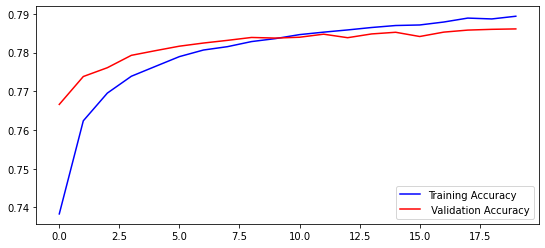

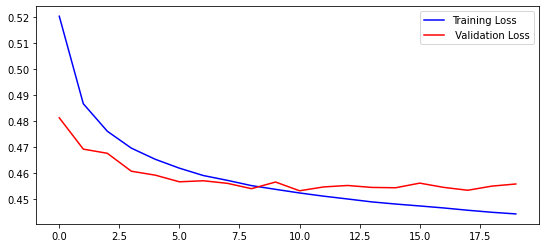

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize = (9,4))
plt.plot(acc, color = 'blue', label = 'Training Accuracy')
plt.plot(val_acc, color = 'red', label = ' Validation Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize= (9,4))
plt.plot(loss,color = 'blue', label = 'Training Loss')
plt.plot(val_loss, color = 'red', label = ' Validation Loss')
plt.legend(loc='upper right')

In [93]:
def decode_sentiment(score):
    return 'Positive' if score > 0.5 else 'Negative'
        
scores = model.predict(x_test, verbose = 1, batch_size = 10000)
y_pred_D = [decode_sentiment(score) for score in scores]

2023-01-09 23:10:49.325525: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 38400000 exceeds 10% of free system memory.


32/32 [==============================] - 2s 40ms/step


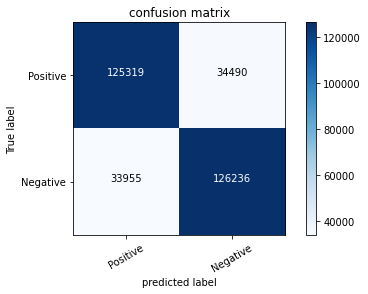

In [94]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap =cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
             horizontalalignment= 'center',
             color = "white" if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

cnf_matrix = confusion_matrix(test_data.sentiment.tolist(), y_pred_D)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = test_data.sentiment.unique(), title = 'confusion matrix')
plt.show()

In [95]:
accuracy = max(acc)
print('Accuracy of model :', accuracy)

Accuracy of model : 0.7893820405006409


Precision, recall, and f1-score of the model

In [96]:
print(classification_report(list(test_data.sentiment), y_pred_D))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.79    159809
    Positive       0.79      0.79      0.79    160191

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [97]:
def final_sentiment(score):
    if score > 0.6:
            return 'Positive'
    elif (score > 0.4 and score < 0.6):
            return 'Neutral'
    else:
            return'Negative'
        
def pred(text):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length) 
    score = model.predict([x_test])[0]
    label = final_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

**7. Test model on actual tweets**

Pull tweets from a certain user (Elon Musk).

In [98]:
posts = api.user_timeline(screen_name = "elonmusk", count = 10, lang = "en", tweet_mode="extended")

sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

print('--------Tweets: ')
print('\n')

for tweet in posts:
    print(tweet.full_text)
    prediction = pred(tweet.full_text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
    
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   
avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))
if avg > 0.6:
    print('The final grade is therefore positive.')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral.')
else:
    print('The final grade is therefore negative.')

--------Tweets: 


RT @SpaceX: All cargo is loaded, the hatch is closed, and Dragon is ready for an on-time departure from the @space_station at 5:05 p.m. ET.…
{'label': 'Negative', 'score': 0.33540335297584534, 'elapsed_time': 0.41561174392700195}


@TrungTPhan That is dedication
{'label': 'Positive', 'score': 0.766482949256897, 'elapsed_time': 0.044478654861450195}


More Twitter Files. 

Some conspiracies are actually true. https://t.co/0OgDkvWsq0
{'label': 'Neutral', 'score': 0.4767405688762665, 'elapsed_time': 0.042688608169555664}


@BillyM2k We will strive to increase the joy of Twitter!
{'label': 'Positive', 'score': 0.7617800235748291, 'elapsed_time': 0.042487382888793945}


@ggreenwald Tragic
{'label': 'Negative', 'score': 0.06612414866685867, 'elapsed_time': 0.042067766189575195}


RT @Tesla: Watch live TV &amp; stream your favorite shows in your Tesla when parked
{'label': 'Neutral', 'score': 0.4171193838119507, 'elapsed_time': 0.04365062713623047}


@paulg New UI coming th

Pull tweets about a certain topic (sports).

In [99]:
search_term = '|'.join(['sport', 'player', 'game', 'ball'])

tweet_amount = 5
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')  

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


@dj_mcghee09 @SupporterYelich @RefereeTwit @BrettKollmann I would add that the NFL is unique from a team sport wher… https://t.co/t4vOHMofmc
{'label': 'Positive', 'score': 0.7969449758529663, 'elapsed_time': 0.04735755920410156}


@ricknasty629 @NFL_DovKleiman is hillis a 24 yr old current sport ball player who had cardiac arrest mid game? just… https://t.co/rFVG89XUoC
{'label': 'Neutral', 'score': 0.552001953125, 'elapsed_time': 0.04280543327331543}


RT @videolib_store: American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron #offense…
{'label': 'Neutral', 'score': 0.5682752132415771, 'elapsed_time': 0.04205441474914551}


American Football
https://t.co/kfoH9NvSJj

#american #ball #defense #down #football #game #goalpost #gridiron… https://t.co/2dGctlBHM0
{'label': 'Positive', 'score': 0.7649737596511841, 'elapsed_time': 0.04216408729553223}


Football Allstars (Soccer)
https://t.co/vk6bZPKXhg

#3d #ball #cinema4

In [100]:
search_term = '|'.join(['work', 'job', 'commute'])
tweet_amount = 5
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

tweets = tweepy.Cursor(api.search_tweets, q = search_term, lang = 'en').items(tweet_amount)
print('--------Tweets: ')
print('\n')

for tweet in tweets:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp = prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg))

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

--------Tweets: 


Missing Nashville, wonder if work will let me remote work from there 🤔 or can the @Titans give me a job, I'm good w… https://t.co/PZofZ76M39
{'label': 'Negative', 'score': 0.2619777321815491, 'elapsed_time': 0.04540610313415527}


@pvotro My daily commute is 16 miles, and sadly active transportation infrastructure is not advancing quickly. This… https://t.co/A5UCjqSzSu
{'label': 'Negative', 'score': 0.2101554125547409, 'elapsed_time': 0.04852581024169922}


@matt_kercher when it rains it pours. Choose wisely!
1) Benefits
2) Work environment
3) Commute
4) Job satisfaction… https://t.co/CPvXDLoB0B
{'label': 'Negative', 'score': 0.2449059635400772, 'elapsed_time': 0.043106794357299805}


@FreddyInSpace My new job is hybrid and my manager already thinks 3-day office weeks are too much. 

Who is liking… https://t.co/FPDBZf4ye7
{'label': 'Neutral', 'score': 0.5929185748100281, 'elapsed_time': 0.04333615303039551}


Imagine hiring a writer and expecting them to work in offi

Pull tweets with certain queries (cars)

In [101]:
client = tweepy.Client(bearer_token = 'AAAAAAAAAAAAAAAAAAAAADvCkQEAAAAAqBldguiK%2FewFmwE1Cpd1UbQrlew%3D4Ysvdx21ITFfLHDHTL5nnV8q5KCNJ8dOLrYf23yIE8S3OOnCvw')
query = '#cars -is:retweet lang:en'
tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)
sums = 0.
counter = 0
pos = 0
neg = 0
neu = 0

for tweet in tweets.data:
    print(tweet.text)
    prediction = pred(tweet.text)
    
    temp =prediction.get('score')
    sums += temp
    counter += 1
    
    temp2 = prediction.get('label')
    if temp2 == 'Positive':
        pos += 1
    elif temp2 == 'Negative':
        neg += 1
    else:
        neu += 1
    print(prediction)    
    print('\n')
print('---------------------------------------------------------------------------------------')
print('There are '+ str(pos)+' positive tweets, '+str(neg) +' negative tweets, and '+str(neu) +' neutral tweets')   

avg = sums/counter
print('The average score of all the retrieved tweets is ' +str(avg)) 

if avg > 0.6:
    print('The final grade is therefore positive')
elif (avg > 0.4 and avg < 0.6):
    print('The final grade is therefore neutral')
else:
    print('The final grade is therefore negative')

2021 Mitsubishi Outlander Sport [$19,900] Great for small family. | For Sale | Call/Text 469-929-4777 - For more Info and appointments #cars
#cardealership #dallas #texas #usedcar #usedcardealership #car #vehicle #carsale #sale #carsforsale https://t.co/J7hVYn8lxB
{'label': 'Neutral', 'score': 0.5371952056884766, 'elapsed_time': 0.04565715789794922}


I'm not old I'm classic Bel Air - Vintage. Available on over 96 #redbubble products! #stickers #tshirts #mugs #masks #magnets #classiccar #cars  #OldCarNutz #vintage #GM #Chevrolet #BelAire #1957
https://t.co/AZx6NiP5qo
{'label': 'Positive', 'score': 0.7036219239234924, 'elapsed_time': 0.043122291564941406}


1 ferrari 599 gto draw carstoon concept Canvas Print #cars #ArtistOnTwitter #drawings - https://t.co/f3GCvzeQTv https://t.co/GmyOtctaju
{'label': 'Positive', 'score': 0.8564727306365967, 'elapsed_time': 0.04233956336975098}


#Cars #Motors #ElectricVehicle This 2,040 HP Electric Hypercar Is Aiming to Set a Nürburgring Lap Record http